# Data Scraping

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import lxml
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [14]:
# Retrieve the list of all rain gauge stations
url = 'https://sdatelemetry.com/newfms/datach.php'
response = requests.get(url)
soup = bs(response.text, 'lxml')

station_links = soup.find_all('a', href = lambda x: x and 'detailposch.php' in x)
stations = []

for link in station_links:
    stations.append([link.text.strip().split('-')[0].strip(), link['href'].split('=')[1].strip()])
    
for i in range(5):
    print(stations[i][0], '->', stations[i][1])

bojongmurni -> aptechv2a_a5&dt
gadog -> aptechnw_h16&dt
kp.kalapa -> kampungkalapa&dt
plta kracak -> aptechv2_z2&dt
cawang -> cawang&dt


In [24]:
# Mining data from the selected station
station = stations[4][1] # Cawang rain gauge station
rainfall_url = 'https://sdatelemetry.com/newfms/detailposch.php?id= ' + station + '='
count = 0

rainfall_data = []
def scrape_data(date):
    global count
    post_response = requests.get(rainfall_url + date.strftime('%Y-%m-%d'))
    post_soup = bs(post_response.text, 'lxml')
    table = post_soup.find_all('tr')[1:]
    
    for row in table:
        rainfall_data.append([data.get_text(strip = True) for data in row.find_all('td')])
            
    count += 1
    if count % 60 == 0: print(date)

start_date = datetime.datetime(2024, 11, 29)
end_date = datetime.datetime(2025, 1, 31)
curr_date = start_date
while curr_date <= end_date:
    scrape_data(curr_date)
    curr_date += datetime.timedelta(days = 1)

2025-01-27 00:00:00


In [25]:
column_name = ['Date', 'Time', 'Rainfall (mm)', 'Status']

rainfall_df = pd.DataFrame(data = rainfall_data, columns = column_name)
rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].str.split(' ').str[0]
rainfall_df['Time'] = rainfall_df['Time'].str.replace('.', ':', regex = False)
rainfall_df['Time'] = pd.to_datetime(rainfall_df['Time'], format = '%H:%M').dt.time
rainfall_df['Date'] = pd.to_datetime(rainfall_df['Date'], format = '%d/%m/%Y')
rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].str.replace(',', '', regex = False)
rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].astype('float')

rainfall_df.dropna(inplace = True)
rainfall_df.reset_index(inplace = True)
rainfall_df.drop(['index', 'Status'], axis = 1, inplace = True)
rainfall_df

,Date,Time,Rainfall (mm)
0,2024-11-29,23:00:00,0.0
1,2024-11-29,22:00:00,0.0
2,2024-11-29,21:00:00,0.0
3,2024-11-29,20:00:00,0.0
4,2024-11-29,19:00:00,0.0
...,...,...,...
1383,2025-01-31,04:00:00,0.0
1384,2025-01-31,03:00:00,0.0
1385,2025-01-31,02:00:00,0.5
1386,2025-01-31,01:00:00,3.0


In [26]:
rainfall_df.to_csv('rainfall_df_cawang.csv', index = False)

# Data Validation

In [28]:
# Combining 2 datasets into 1 by joining the time
def mergedf(post_name, sta_name, station, post):
    post_df = pd.read_csv('rainfall_df_' + post_name + '.csv')
    post_df.sort_values(by = ['Date', 'Time'], ascending = [1, 1], inplace = True)
    post_df["datetime"] = pd.to_datetime(post_df["Date"] + ' ' + post_df["Time"], format = '%Y-%m-%d %H:%M:%S')
    post_df.drop(['Date', 'Time'], axis = 1, inplace = True)
    post_df['Rainfall (mm)'] = post_df['Rainfall (mm)'].astype('float')
    post_df['datetime'] = post_df['datetime'] - pd.Timedelta(hours = 7)
    post_df['date'] = post_df['datetime'].dt.date
    post_df = post_df.groupby('date')['Rainfall (mm)'].sum()
    post_df = post_df.to_frame()
    post_df.reset_index(inplace = True)
    post_df['date'] = pd.to_datetime(post_df['date'], format = '%Y-%m-%d')

    sta_df = pd.read_excel(sta_name + '.xlsx')
    sta_df.loc[sta_df['RR'] == '-', 'RR'] = np.nan
    sta_df = sta_df[(sta_df['RR'] < 8888) | (sta_df['RR'].isna())]
    sta_df['Date'] = pd.to_datetime(sta_df['Date'], format = '%d-%m-%Y')
    
    daterange = pd.date_range(
        start = post_df['date'].min(),
        end = post_df['date'].max(),
        freq = 'D'
    )
    
    sta_df.set_index('Date', inplace = True)
    sta_df = sta_df[~sta_df.index.duplicated(keep='first')]
    sta_df = sta_df.reindex(daterange)
    sta_df.reset_index(inplace = True)
    sta_df.rename(columns = {'index': 'Date'}, inplace = True)
    
    post_df.set_index('date', inplace = True)
    post_df = post_df.reindex(daterange)
    post_df.reset_index(inplace = True)
    post_df.rename(columns = {'index': 'date'}, inplace = True)
    
    merged = pd.merge(post_df, sta_df, left_on = 'date', right_on = 'Date', how = 'inner')
    merged.drop(['Date'], axis = 1, inplace = True)
    merged.rename(columns = {
        'date': 'Date',
        'Rainfall (mm)': f'{post} Station Rainfall (mm)',
        'RR': f'{station} Station Rainfall (mm)'
    }, inplace = True)
    
    if post == 'Cawang': merged = merged[merged['Date'] > '2017-12-31'].dropna()
    elif station == 'Banten Climatology' or station == 'West Java Climatology': merged.dropna(subset=[f'{station} Station Rainfall (mm)'], inplace = True)
    else: merged.dropna(inplace = True)

    post_col = f'{post} Station Rainfall (mm)'
    sta_col = f'{station} Station Rainfall (mm)'

    daterange = pd.date_range(
        start = merged['Date'].min(),
        end = merged['Date'].max(),
        freq = 'D'
    )
    
    merged.set_index('Date', inplace = True)
    merged = merged.reindex(daterange)
    merged.reset_index(inplace = True)
    merged.rename(columns = {'index': 'Date'}, inplace = True)
    
    return merged

# Saving the results to Excel
def save_excel(dataset, sheet_name):
    with pd.ExcelWriter(
        'Pos Hujan vs BMKG_NaN.xlsx',
        engine = 'openpyxl',
        mode = 'a',
        if_sheet_exists = 'replace'
    ) as writer:
        dataset.to_excel(writer, sheet_name = sheet_name, index = False)

# Visualizing both datasets for visual comparison
def plot(merged_df, sta_name, post_name):
    rain = max(merged_df, key=len)

    # Create boolean mask for isolated rainfall points
    isolated_mask = (rain[f'{sta_name} Station Rainfall (mm)'].notna()) & (rain[f'{sta_name} Station Rainfall (mm)'].shift(1).isna()) & (rain[f'{sta_name} Station Rainfall (mm)'].shift(-1).isna())

    plt.rcParams.update({
        'axes.labelsize': 14,  # Axis labels
        'axes.titlesize': 14,  # Title
        'xtick.labelsize': 14,  # X-axis tick labels
        'ytick.labelsize': 14,  # Y-axis tick labels
        'legend.fontsize': 14   # Legend font size
    })
    plt.figure(figsize = (10, 5))
    
    if sta_name == 'West Java Climatology': plt.figure(figsize = (10,6))
        
    plt.plot(max(merged_df, key=len)['Date'], max(merged_df, key=len)[f'{sta_name} Station Rainfall (mm)'], label = f'{sta_name} Station')
    plt.scatter(max(merged_df, key=len)['Date'], max(merged_df, key=len)[f'{sta_name} Station Rainfall (mm)'], s = 1, label = '_nolegend_')
    
    for df, post in zip(merged_df, post_name):
        isolated_mask = (df[f'{post} Station Rainfall (mm)'].notna()) & (df[f'{post} Station Rainfall (mm)'].shift(1).isna()) & (df[f'{post} Station Rainfall (mm)'].shift(-1).isna())
        plt.plot(df['Date'], df[f'{post} Station Rainfall (mm)'], label = f'{post} Station')
        plt.scatter(df['Date'][isolated_mask], df[f'{post} Station Rainfall (mm)'][isolated_mask], s = 10, label = '_nolegend_')

    xmin, xmax = min([df['Date'].min() for df in merged_df]), max([df['Date'].max() for df in merged_df])
    ymax = max([df.iloc[:, 1].max() for df in merged_df] + [df.iloc[:, 2].max() for df in merged_df])
    plt.xlim(pd.to_datetime([xmin, xmax]))
    plt.ylim(top = ymax + 30)
    plt.legend()
    plt.xticks(rotation = 20)
    
    plt.ylabel('Rainfall (mm)')
    plt.xlabel('Date')
    
    if len(post_name) == 1: plt.title(f'Daily Rainfall Comparison between {sta_name} Station and {post_name[0]} Station')
    else: plt.title(f'Daily Rainfall Comparison between {sta_name} Station and Nearby Stations')
        
    plt.grid(visible = True)
    plt.tight_layout()
    
# Calculating the regression metrics
def perform_metrics(dataframe, sta_post_names, station, post):
    data = dataframe.dropna()
    errors = {}
    errors['BBWSCC Rain Gauge Station'] = post
    errors['BMKG'] = f'{station} Station'
    errors['MSE'] = mean_squared_error(data[f'{station} Station Rainfall (mm)'], data[f'{post} Station Rainfall (mm)'])
    errors['RMSE'] = round(errors['MSE']**.5, 4)
    errors['MSE'] = round(errors['MSE'], 4)
    errors['MAE'] = round(mean_absolute_error(data[f'{station} Station Rainfall (mm)'], data[f'{post} Station Rainfall (mm)']), 4)
    errors['R2'] = round(r2_score(data[f'{station} Station Rainfall (mm)'], data[f'{post} Station Rainfall (mm)']), 4)
    
    error_summary[sta_post_names] = [x for x in errors.values()]
    
    return pd.DataFrame(data = error_summary[sta_post_names], 
             columns = ['Value'], index = errors.keys())

In [16]:
error_summary = {}

## Cawang X Stasiun Halim Perdanakusuma

In [17]:
cawang_halim = mergedf('cawang', 'Stasiun Halim Perdanakusuma', 'Halim Perdanakusuma', 'Cawang')
#save_excel(cawang_halim, 'Cawang x Halim')

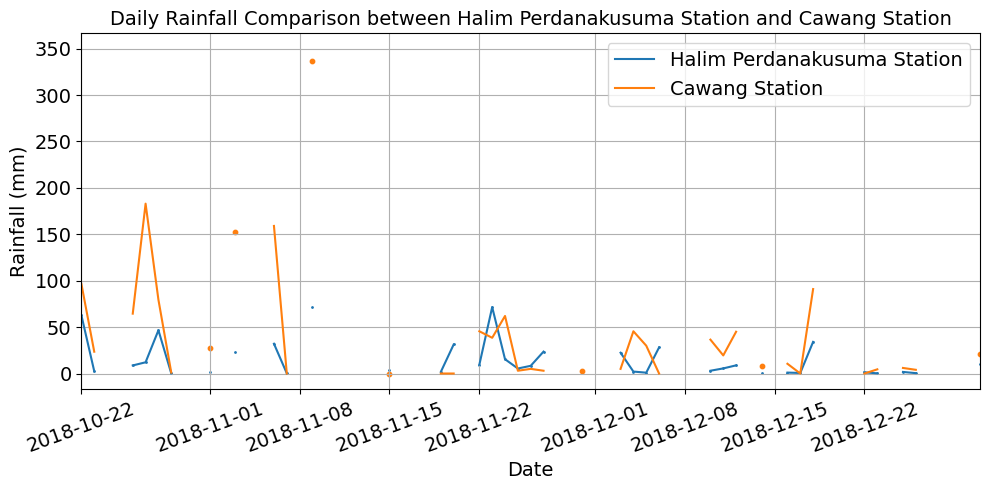

In [29]:
plot([cawang_halim], 'Halim Perdanakusuma', ['Cawang'])

In [25]:
perform_metrics(cawang_halim_harian, '2', 'Halim Perdanakusuma', 'Cawang')

,Value
BBWSCC Rain Gauge Station,Cawang (Daily)
BMKG,Halim Perdanakusuma Station (Daily)
MSE,4175.3024
RMSE,64.6166
MAE,36.3649
R2,-9.6155


## Bendung Pasar Baru X Stasiun Geofisika Tangerang

In [30]:
pasarbaru_tangerang = mergedf('pasarbaru', 'Stasiun Geofisika Tangerang', 'Tangerang Geophysics', 'Bendung Pasar Baru')
#save_excel(pasarbaru_tangerang, 'Bendung Pasar Baru x Tangerang')

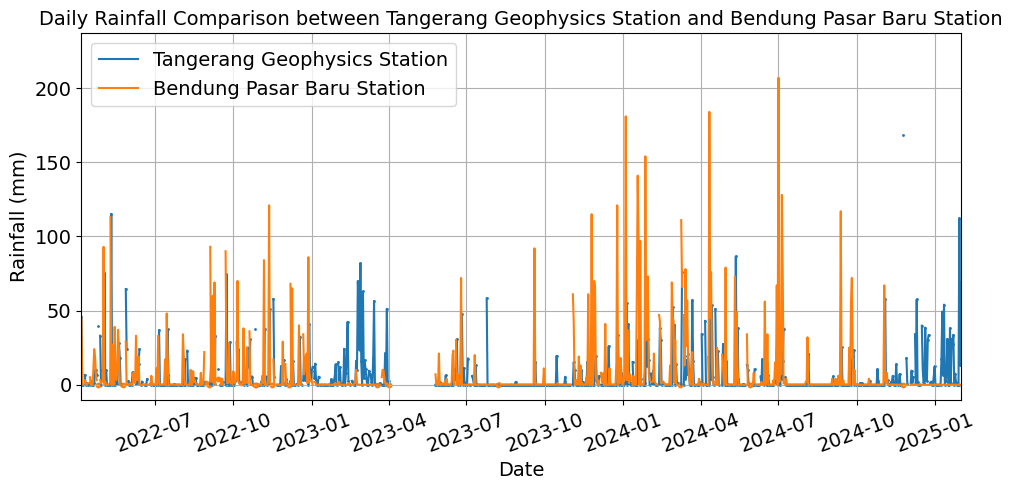

In [31]:
plot([pasarbaru_tangerang], 'Tangerang Geophysics', ['Bendung Pasar Baru'])

In [19]:
perform_metrics(pasarbaru_tangerang, '3', 'Tangerang Geophysics', 'Bendung Pasar Baru')

,Value
BBWSCC Rain Gauge Station,Bendung Pasar Baru
BMKG,Tangerang Geophysics Station
MSE,735.2646
RMSE,27.1158
MAE,11.6694
R2,-2.1595


## AWS Ciawi X Stasiun Klimatologi Banten

In [32]:
ciawi_banten = mergedf('awsciawi', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'AWS Ciawi')
#save_excel(ciawi_banten, 'Ciawi x Banten')

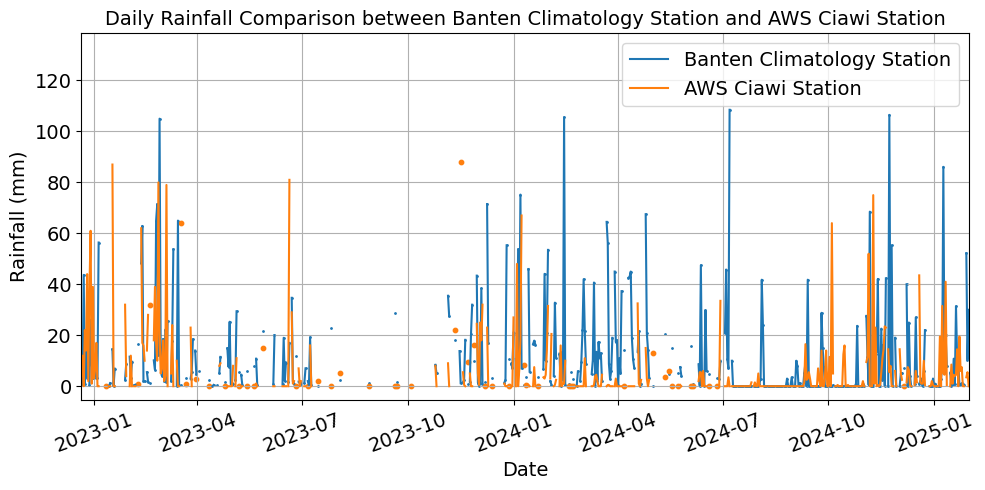

In [33]:
plot([ciawi_banten], 'Banten Climatology', ['AWS Ciawi'])

In [22]:
perform_metrics(ciawi_banten, '4', 'Banten Climatology', 'AWS Ciawi')

,Value
BBWSCC Rain Gauge Station,AWS Ciawi
BMKG,Banten Climatology Station
MSE,514.5254
RMSE,22.6832
MAE,12.6313
R2,-0.561


## Situ Parigi X Stasiun Klimatologi Banten

In [34]:
situparigi_banten = mergedf('situparigi', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'Situ Parigi')
#save_excel(situparigi_banten, 'Situ Parigi x Banten')

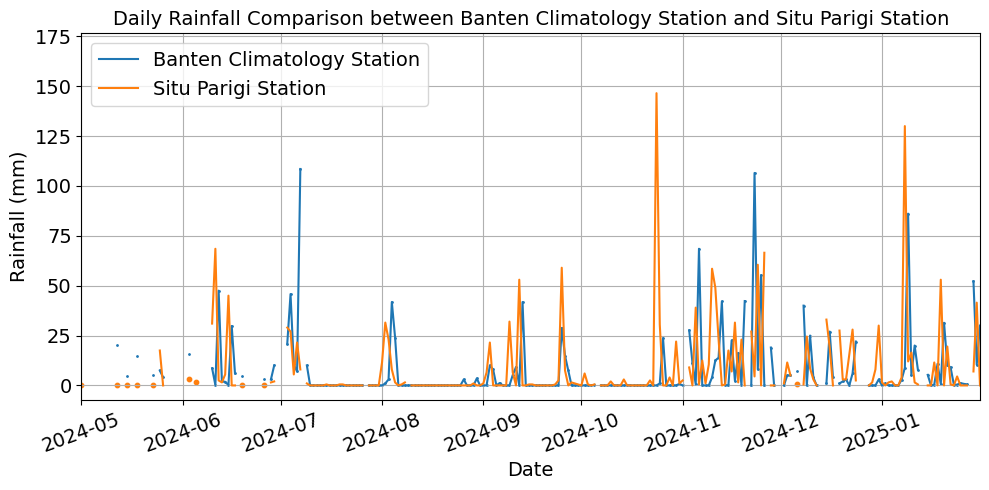

In [35]:
plot([situparigi_banten], 'Banten Climatology', ['Situ Parigi'])

In [24]:
perform_metrics(situparigi_banten, '5', 'Banten Climatology', 'Situ Parigi')

,Value
BBWSCC Rain Gauge Station,Situ Parigi
BMKG,Banten Climatology Station
MSE,604.0029
RMSE,24.5765
MAE,11.9902
R2,-1.3106


## Villa Pamulang X Stasiun Klimatologi Banten

In [36]:
pamulang_banten = mergedf('pamulang', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'Villa Pamulang')
#save_excel(pamulang_banten, 'Villa Pamulang x Banten')

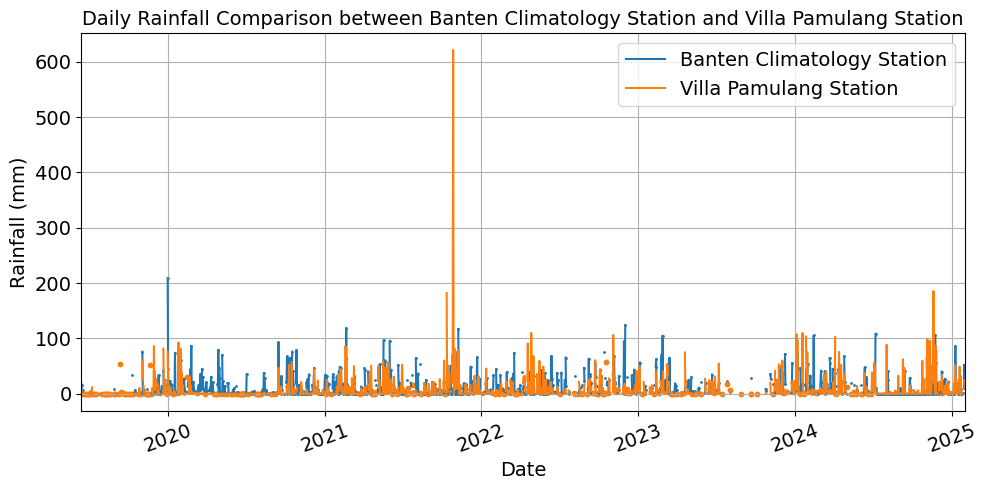

In [37]:
plot([pamulang_banten], 'Banten Climatology', ['Villa Pamulang'])

In [26]:
perform_metrics(pamulang_banten, '6', 'Banten Climatology', 'Villa Pamulang')

,Value
BBWSCC Rain Gauge Station,Villa Pamulang
BMKG,Banten Climatology Station
MSE,934.4684
RMSE,30.5691
MAE,14.4
R2,-1.6057


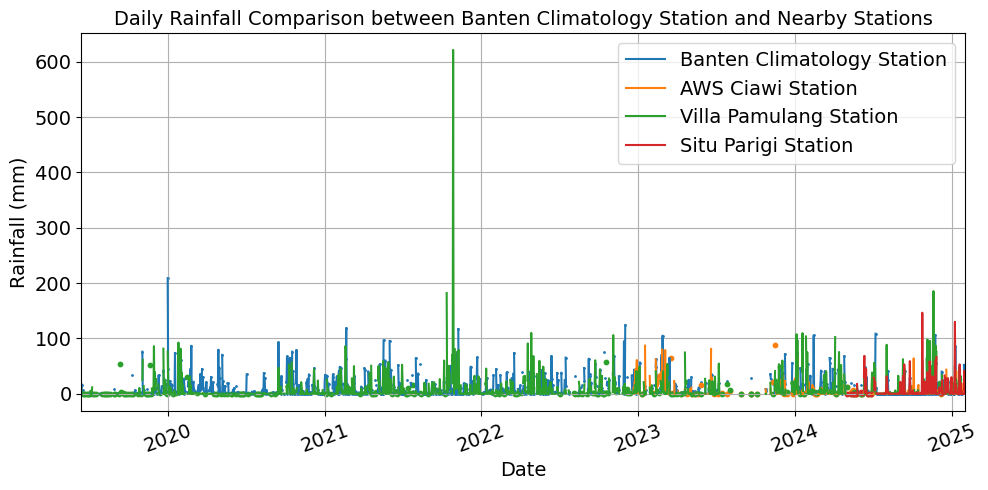

In [38]:
plot([ciawi_banten, pamulang_banten, situparigi_banten], 'Banten Climatology', ['AWS Ciawi', 'Villa Pamulang', 'Situ Parigi'])

## Ranca Bungur X Stasiun Klimatologi Jawa Barat

In [39]:
rancabungur_jawabarat = mergedf('rancabungur', 'Stasiun Klimatologi Jawa Barat', 'West Java Climatology', 'Ranca Bungur')
#save_excel(rancabungur_jawabarat, 'Rancabungur x Jawa Barat')

<Figure size 1000x500 with 0 Axes>

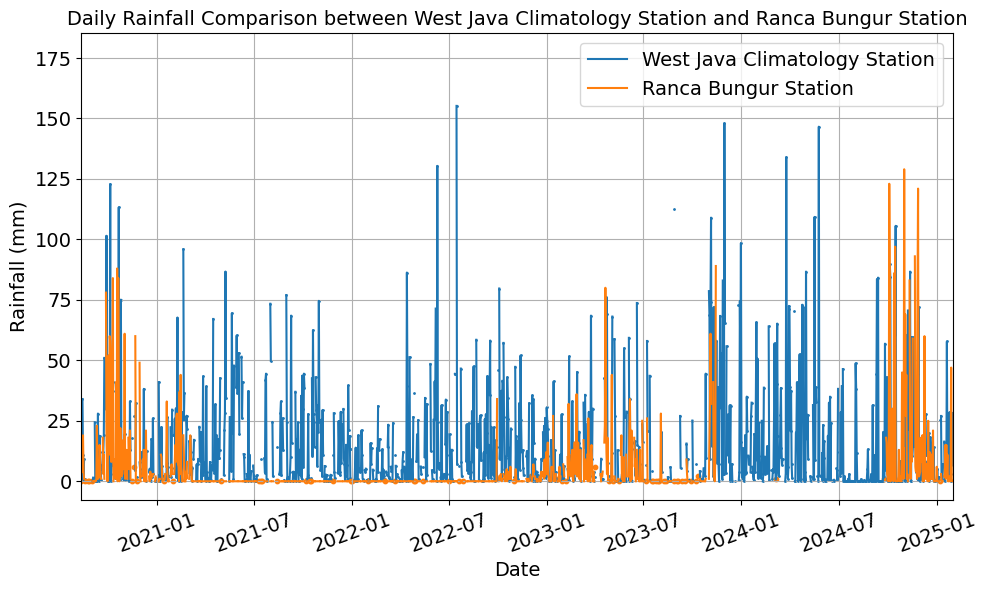

In [40]:
plot([rancabungur_jawabarat], 'West Java Climatology', ['Ranca Bungur'])

In [28]:
perform_metrics(rancabungur_jawabarat, '7', 'West Java Climatology', 'Ranca Bungur')

,Value
BBWSCC Rain Gauge Station,Ranca Bungur
BMKG,West Java Climatology Station
MSE,617.8696
RMSE,24.857
MAE,14.6934
R2,-0.5336


## Situ Lengkong Barang X Stasiun Klimatologi Jawa Barat

In [41]:
lengkong_jawabarat = mergedf('lengkongbarang', 'Stasiun Klimatologi Jawa Barat', 'West Java Climatology', 'Situ Lengkong Barang')
#save_excel(lengkong_jawabarat, 'Situ Lengkong x Jawa Barat')

<Figure size 1000x500 with 0 Axes>

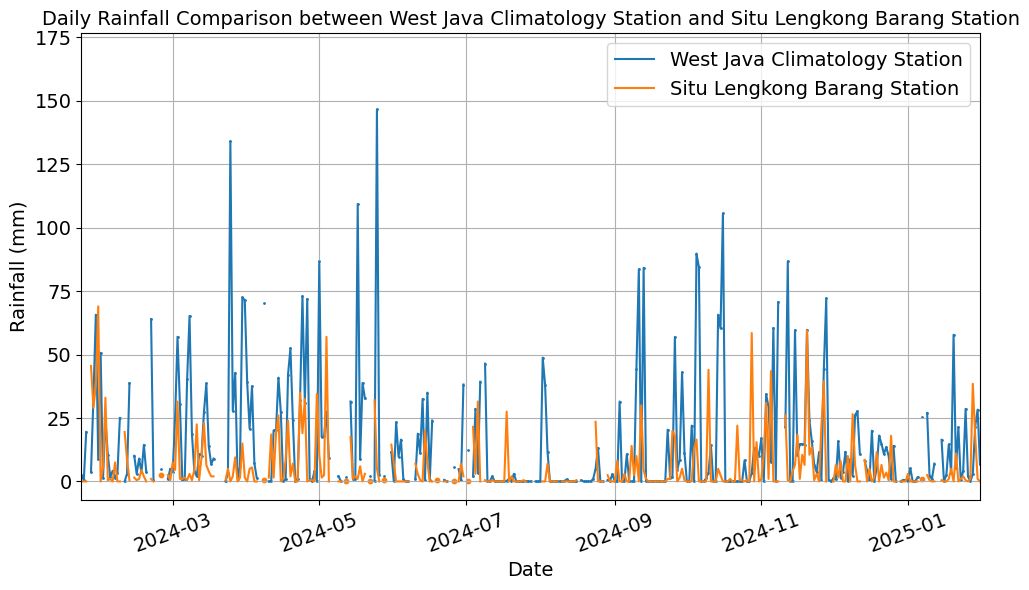

In [42]:
plot([lengkong_jawabarat], 'West Java Climatology', ['Situ Lengkong Barang'])

In [30]:
perform_metrics(lengkong_jawabarat, '8', 'West Java Climatology', 'Situ Lengkong Barang')

,Value
BBWSCC Rain Gauge Station,Situ Lengkong Barang
BMKG,West Java Climatology Station
MSE,740.5791
RMSE,27.2136
MAE,15.3143
R2,-0.2933


<Figure size 1000x500 with 0 Axes>

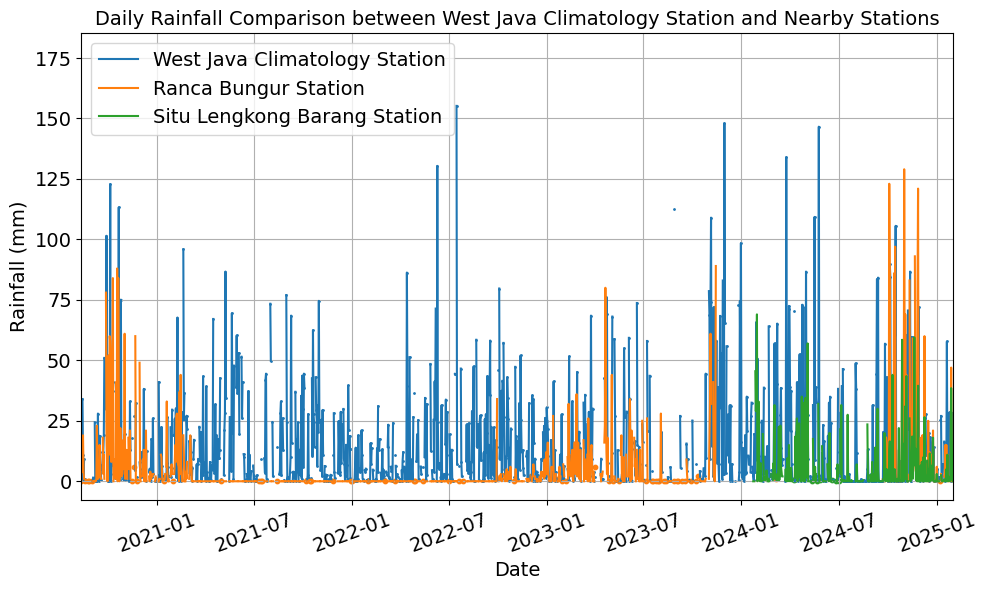

In [43]:
plot([rancabungur_jawabarat, lengkong_jawabarat], 'West Java Climatology', ['Ranca Bungur', 'Situ Lengkong Barang'])

## Pasir Jaya X Stasiun Klimatologi Citeko

In [44]:
pasirjaya_citeko = mergedf('pasirjaya', 'Stasiun Klimatologi Citeko', 'Citeko Climatology', 'Pasir Jaya')
#save_excel(pasirjaya_citeko, 'Pasir x Citeko')
mask = (pasirjaya_citeko['Date'] >= pd.Timestamp(2022, 3, 2)) & (pasirjaya_citeko['Date'] <= pd.Timestamp(2022, 4, 9))

pasirjaya_citeko.loc[mask, 'Pasir Jaya Station Rainfall (mm)'] = np.nan
pasirjaya_citeko.loc[mask, 'Citeko Climatology Station Rainfall (mm)'] = np.nan

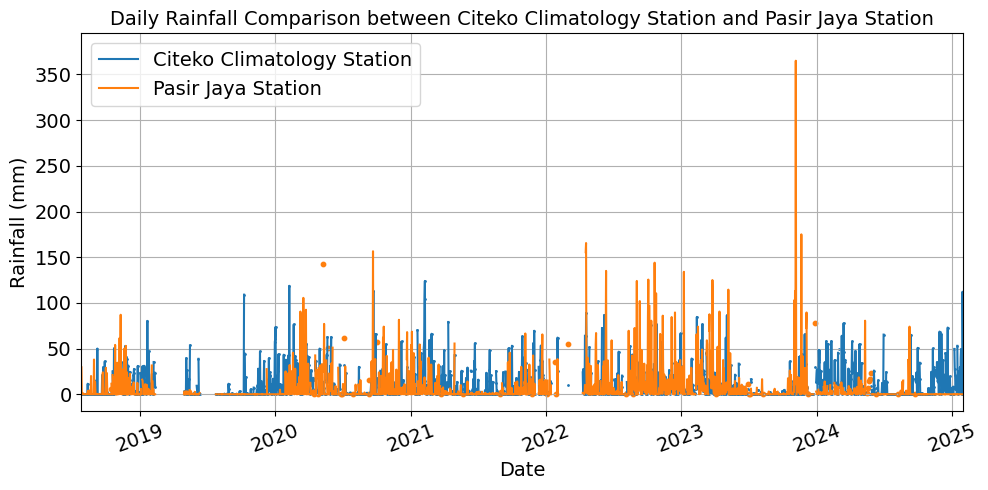

In [45]:
plot([pasirjaya_citeko], 'Citeko Climatology', ['Pasir Jaya'])

In [23]:
perform_metrics(pasirjaya_citeko, '9', 'Citeko Climatology', 'Pasir Jaya')

,Value
BBWSCC Rain Gauge Station,Pasir Jaya
BMKG,Citeko Climatology Station
MSE,630.5071
RMSE,25.1099
MAE,12.6271
R2,-1.4605


## Error Summary

In [34]:
error = pd.DataFrame(data = error_summary.values(),
             columns = ['Rainfall Post', 'BMKG', 'MSE', 'RMSE', 'MAE', 'R2'])

with pd.ExcelWriter(
    'Pos Hujan vs BMKG_NaN.xlsx',
    engine = 'openpyxl',
    mode = 'a',
    if_sheet_exists = 'replace'
) as writer:
    error.to_excel(writer, sheet_name = 'Error Summary', index = True)
    
error

,Rainfall Post,BMKG,MSE,RMSE,MAE,R2
0,Cawang (Daily),Halim Perdanakusuma Station (Daily),3686.8845,60.7197,32.5500,-9.1078
1,Bendung Pasar Baru,Tangerang Geophysics Station,735.2646,27.1158,11.6694,-2.1595
2,AWS Ciawi,Banten Climatology Station,514.5254,22.6832,12.6313,-0.5610
3,Situ Parigi,Banten Climatology Station,604.0029,24.5765,11.9902,-1.3106
4,Villa Pamulang,Banten Climatology Station,934.4684,30.5691,14.4000,-1.6057
5,Ranca Bungur,West Java Climatology Station,617.8696,24.8570,14.6934,-0.5336
6,Situ Lengkong Barang,West Java Climatology Station,740.5791,27.2136,15.3143,-0.2933
7,Pasir Jaya,Citeko Climatology Station,928.1109,30.4649,14.6612,-2.6520


# Annual Rainfall Comparison

In [86]:
post_station = [
    ['Bendung Pasar Baru', 'Tangerang Geophysics Station'], ['Cawang', 'Halim Perdanakusuma Station'],
    ['AWS Ciawi', 'Banten Climatology Station'], ['Situ Parigi', 'Banten Climatology Station'],
    ['Villa Pamulang', 'Banten Climatology Station'], ['Ranca Bungur', 'West Java Climatology Station'],
    ['Situ Lengkong Barang', 'West Java Climatology Station'], ['Pasir Jaya', 'Citeko Climatology Station']
]

merged = [
    pasarbaru_tangerang, cawang_halim_harian, ciawi_banten, situparigi_banten,
    pamulang_banten, rancabungur_jawabarat, lengkong_jawabarat, pasirjaya_citeko
]

yearly_rainfall = []

for idx, df in enumerate(merged):
    df.dropna(inplace = True)
    date = 'Date'
    #if idx == 2: date = 'Month' 
    #elif idx == 1: df = df[~df['Date'].dt.year.isin([2019, 2020, 2021, 2022])]
    #df.fillna(0, inplace = True)
    for row in (
        #df.groupby( # Count
        df.fillna(0).groupby( # Sum
            df[date].dt.year, dropna = False
        ).sum().itertuples(name=None)
    ):
        print(row)
        yearly_rainfall.append([post_station[idx][0], post_station[idx][1], row[0], row[1], row[2]])
        
yearly = pd.DataFrame(data = yearly_rainfall, columns = ['Rainfall Post', 'BMKG', 'Year', 'Rainfall Post Yearly Rainfall (mm)', 'BMKG Yearly Rainfall (mm)'])
yearly.sort_values(['Rainfall Post', 'Year'], inplace = True)
yearly['BMKG Yearly Rainfall (mm)'].replace(0, np.nan, inplace = True)

with pd.ExcelWriter(
    'frequency_summary.xlsx',
    engine = 'openpyxl',
    mode = 'a',
    if_sheet_exists = 'overlay'
) as writer:
    yearly.to_excel(writer, sheet_name = 'Curah Hujan Tahunan', index = False, startcol = 8)

(2022, 2059.0, 1558.6)
(2023, 1098.0, 1270.2)
(2024, 3499.0, 2214.6)
(2025, 0.0, 505.3)
(2018, 1610.5, 553.0)
(2022, 237.0, 131.6)
(2023, 1261.5, 1607.8)
(2024, 1044.5, 2697.7)
(2025, 181.0, 295.4)
(2024, 1434.5, 1230.4)
(2025, 307.0, 295.4)
(2019, 578.5, 365.0)
(2020, 874.0, 2644.1)
(2021, 3305.0, 3004.8)
(2022, 1906.0, 2883.0)
(2023, 1167.5, 1637.4)
(2024, 2996.5, 2697.7)
(2025, 286.5, 295.4)
(2020, 1310.0, 1314.6)
(2021, 389.0, 3786.6)
(2022, 151.0, 3505.9)
(2023, 1278.0, 2600.3)
(2024, 1709.0, 1382.5)
(2025, 109.0, 285.1)
(2024, 1729.5, 4601.0)
(2025, 86.5, 285.1)
(2018, 921.0, 890.4)
(2019, 199.5, 1377.1)
(2020, 2828.0, 3391.8)
(2021, 1476.5, 3334.3)
(2022, 3847.5, 2932.6)
(2023, 3554.0, 2160.0)
(2024, 642.5, 3136.5)
(2025, 0.0, 581.9)


# Comparison Using 1:1 Line

In [23]:
def mergedf(post_name, sta_name, station, post):
    post_df = pd.read_csv('rainfall_df_' + post_name + '.csv')
    post_df.sort_values(by = ['Date', 'Time'], ascending = [1, 1], inplace = True)
    post_df["datetime"] = pd.to_datetime(post_df["Date"] + ' ' + post_df["Time"], format = '%Y-%m-%d %H:%M:%S')
    post_df.drop(['Date', 'Time'], axis = 1, inplace = True)
    post_df['Rainfall (mm)'] = post_df['Rainfall (mm)'].astype('float')
    post_df['datetime'] = post_df['datetime'] - pd.Timedelta(hours = 7)
    post_df['date'] = post_df['datetime'].dt.date
    post_df = post_df.groupby('date')['Rainfall (mm)'].sum()
    post_df = post_df.to_frame()
    post_df.reset_index(inplace = True)
    post_df['date'] = pd.to_datetime(post_df['date'], format = '%Y-%m-%d')

    sta_df = pd.read_excel(sta_name + '.xlsx')
    #sta_df.fillna(0, inplace = True)   # Assume empty = 0
    sta_df.loc[sta_df['RR'] == '-', 'RR'] = np.nan
    sta_df = sta_df[(sta_df['RR'] < 8888) | (sta_df['RR'].isna())]
    sta_df['Date'] = pd.to_datetime(sta_df['Date'], format = '%d-%m-%Y')
    
    daterange = pd.date_range(
        start = post_df['date'].min(),
        end = post_df['date'].max(),
        freq = 'D'
    )
    sta_df.set_index('Date', inplace = True)
    sta_df = sta_df[~sta_df.index.duplicated(keep='first')]
    sta_df = sta_df.reindex(daterange)
    sta_df.reset_index(inplace = True)
    sta_df.rename(columns = {'index': 'Date'}, inplace = True)
    
    post_df.set_index('date', inplace = True)
    post_df = post_df.reindex(daterange)
    post_df.reset_index(inplace = True)
    post_df.rename(columns = {'index': 'date'}, inplace = True)
    
    merged = pd.merge(post_df, sta_df, left_on = 'date', right_on = 'Date', how = 'inner')
    merged.drop(['Date'], axis = 1, inplace = True)
    merged.rename(columns = {
        'date': 'Date',
        'Rainfall (mm)': f'{post} Station Rainfall (mm)',
        'RR': f'{station} Station Rainfall (mm)'
    }, inplace = True)
    if post == 'Cawang': merged = merged[merged['Date'] > '2017-12-31'].dropna()
    elif station == 'Banten Climatology' or station == 'West Java Climatology': merged.dropna(subset=[f'{station} Station Rainfall (mm)'], inplace = True)
    else: merged.dropna(inplace = True)
        
    post_col = f'{post} Station Rainfall (mm)'
    sta_col = f'{station} Station Rainfall (mm)'

    valid_mask = merged[post_col].notna() & merged[sta_col].notna()
    
    daterange = pd.date_range(
        start = merged['Date'].min(),
        end = merged['Date'].max(),
        freq = 'D'
    )
    
    merged.set_index('Date', inplace = True)
    merged = merged.reindex(daterange)
    merged.reset_index(inplace = True)
    merged.rename(columns = {'index': 'Date'}, inplace = True)
    
    return merged

def plot(merged_df, sta_name, post_name):
    global order
    rain = max(merged_df, key=len)

    # Create boolean mask for isolated rainfall points
    isolated_mask = (rain[f'{sta_name} Station Rainfall (mm)'].notna()) & (rain[f'{sta_name} Station Rainfall (mm)'].shift(1).isna()) & (rain[f'{sta_name} Station Rainfall (mm)'].shift(-1).isna())

    sta = sta_name
    plt.rcParams.update({
        'axes.labelsize': 18,  # Axis labels
        'axes.titlesize': 10,  # Title
        'xtick.labelsize': 18,  # X-axis tick labels
        'ytick.labelsize': 18,  # Y-axis tick labels
        'legend.fontsize': 18   # Legend font size
    })

    count = 0
    for df, post in zip(merged_df, post_name):
        x = df[f'{sta_name} Station Rainfall (mm)']
        y = df[f'{post} Station Rainfall (mm)']

        # Drop rows with NaN in either
        valid = x.notna() & y.notna()
        x = x[valid]
        y = y[valid]
        
        # Determine combined min/max
        max_val = max(x.max(), y.max())
        if post == 'Villa Pamulang': axis_min = -5
        elif post == 'Situ Parigi' or post == 'AWS Ciawi' or post == 'Situ Lengkong Barang': axis_min = -1
        elif post == 'Ranca Bungur': axis_min = -2
        else: axis_min = -3
        axis_max = np.ceil(max_val)

        # Tick step suggestion (adaptive)
        if post == 'Villa Pamulang': tick_step = 100
        elif post == 'Situ Parigi' or post == 'AWS Ciawi' or post == 'Situ Lengkong Barang': tick_step = 25
        else: tick_step = 50
        ticks = np.arange(0, axis_max + tick_step, tick_step)
        
        # Create scatter plot
        plt.figure(figsize=(7, 6))
        plt.scatter(x, y, s=15, alpha=0.7, label='Observed')

        # Add 1:1 line (ideal agreement)
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        plt.plot([min_val, axis_max + tick_step], [min_val, axis_max + tick_step], color='red', linestyle='--', label='1:1 Line')

        if post == 'Bendung Pasar Baru' or post == 'AWS Ciawi': count = 0
        elif post == 'Situ Lengkong Barang': count = 1
        elif post == 'Pasir Jaya': count = 3
        plt.xlabel(f'{sta_name} Station Rainfall (mm)\n({order[count]})')
        plt.ylabel(f'{post} Station Rainfall (mm)')
        
        # Axes setup
        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.gca().set_aspect('equal')

        #plt.title(f'Rainfall Comparison: {sta} vs {post}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        count += 1

In [4]:
cawang_halim_harian = mergedf('cawang', 'Stasiun Halim Perdanakusuma', 'Halim Perdanakusuma', 'Cawang')
#save_excel(cawang_halim_harian, 'Cawang x Halim1')
#cawang_halim_harian = cawang_halim_harian[cawang_halim_harian['Date'] > '2017-12-31'].dropna()
#cawang_halim_harian[cawang_halim_harian['Date'] > '2018-09-26']

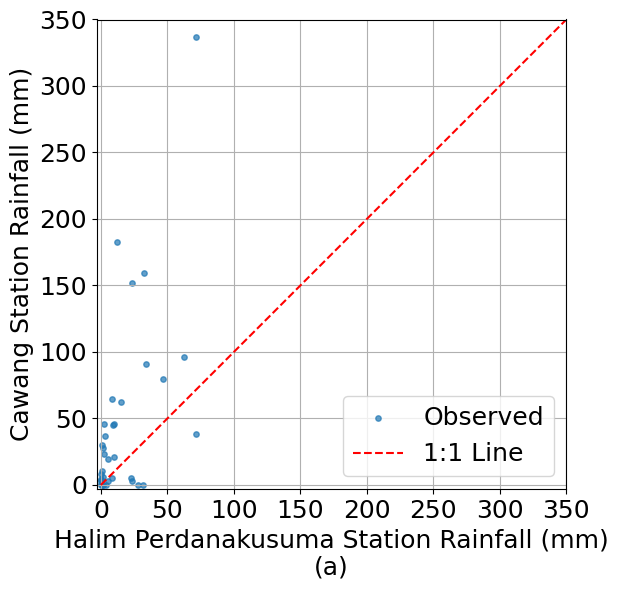

In [8]:
plot([cawang_halim_harian], 'Halim Perdanakusuma', ['Cawang'])

In [9]:
pasarbaru_tangerang = mergedf('pasarbaru', 'Stasiun Geofisika Tangerang', 'Tangerang Geophysics', 'Bendung Pasar Baru')
#save_excel(pasarbaru_tangerang, 'Bendung Pasar Baru x Tangerang')

218

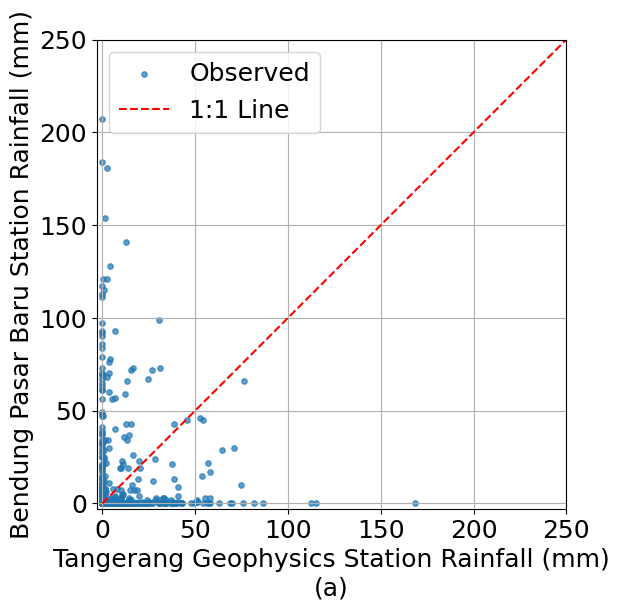

In [21]:
plot([pasarbaru_tangerang], 'Tangerang Geophysics', ['Bendung Pasar Baru'])

## AWS Ciawi X Stasiun Klimatologi Banten

In [11]:
ciawi_banten = mergedf('awsciawi', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'AWS Ciawi')
#save_excel(ciawi_banten, 'Ciawi x Banten')

11

## Situ Parigi X Stasiun Klimatologi Banten

In [12]:
situparigi_banten = mergedf('situparigi', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'Situ Parigi')
#save_excel(situparigi_banten, 'Situ Parigi x Banten')

## Villa Pamulang X Stasiun Klimatologi Banten

In [13]:
pamulang_banten = mergedf('pamulang', 'Stasiun Klimatologi Banten', 'Banten Climatology', 'Villa Pamulang')
#save_excel(pamulang_banten, 'Villa Pamulang x Banten')

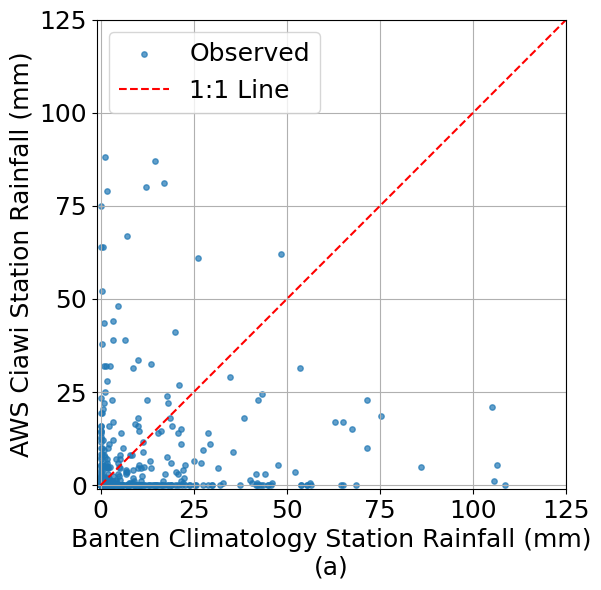

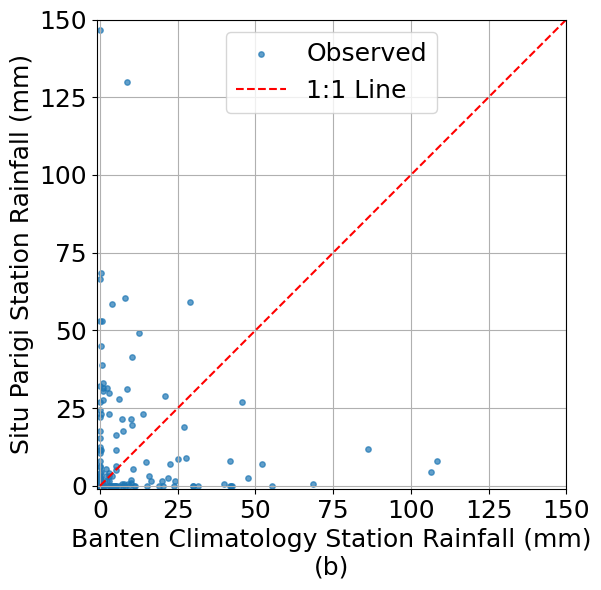

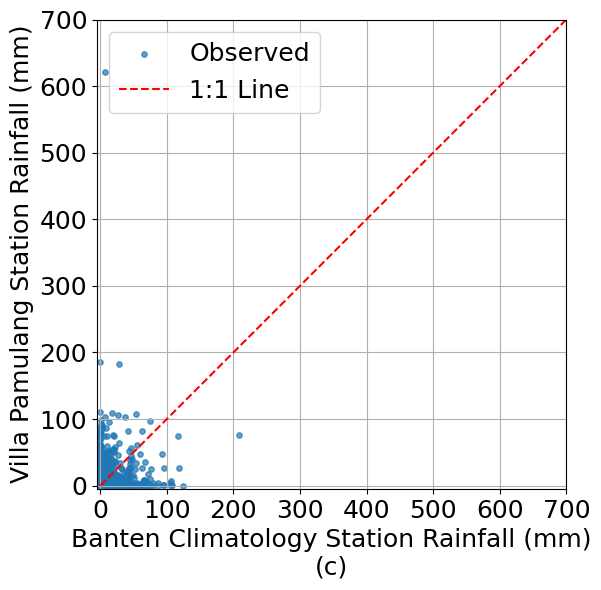

In [14]:
plot([ciawi_banten, situparigi_banten, pamulang_banten], 'Banten Climatology', ['AWS Ciawi', 'Situ Parigi', 'Villa Pamulang'])

## Ranca Bungur X Stasiun Klimatologi Jawa Barat

In [15]:
rancabungur_jawabarat = mergedf('rancabungur', 'Stasiun Klimatologi Jawa Barat', 'West Java Climatology', 'Ranca Bungur')
#save_excel(rancabungur_jawabarat, 'Rancabungur x Jawa Barat')

## Situ Lengkong Barang X Stasiun Klimatologi Jawa Barat

In [16]:
lengkong_jawabarat = mergedf('lengkongbarang', 'Stasiun Klimatologi Jawa Barat', 'West Java Climatology', 'Situ Lengkong Barang')
#save_excel(lengkong_jawabarat, 'Situ Lengkong x Jawa Barat')

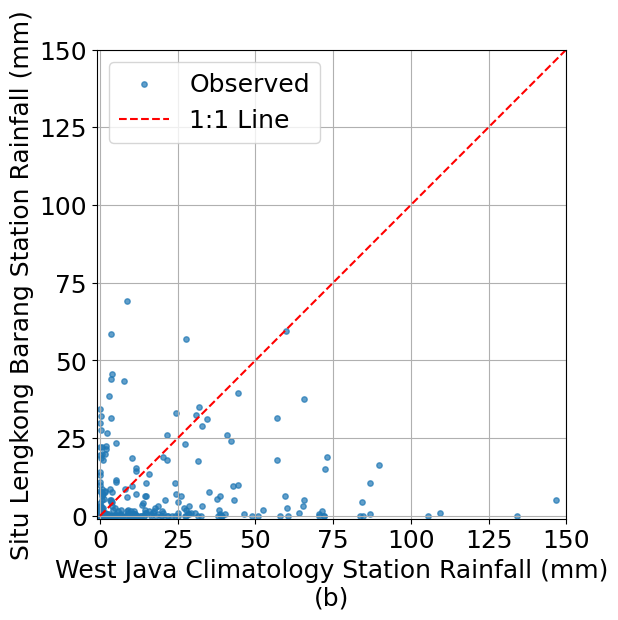

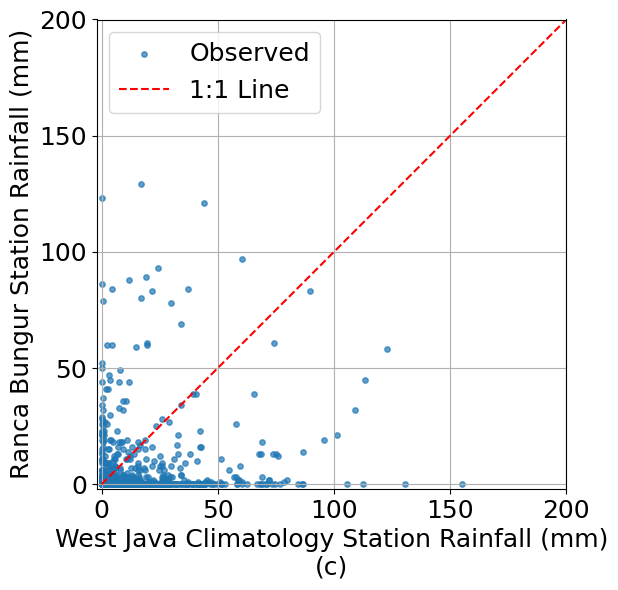

In [22]:
plot([lengkong_jawabarat, rancabungur_jawabarat], 'West Java Climatology', ['Situ Lengkong Barang', 'Ranca Bungur'])

## Pasir Jaya X Stasiun Klimatologi Citeko

In [18]:
pasirjaya_citeko = mergedf('pasirjaya', 'Stasiun Klimatologi Citeko', 'Citeko Climatology', 'Pasir Jaya')
#save_excel(pasirjaya_citeko, 'Pasir x Citeko')
mask = (pasirjaya_citeko['Date'] >= pd.Timestamp(2022, 3, 2)) & (pasirjaya_citeko['Date'] <= pd.Timestamp(2022, 4, 9))

pasirjaya_citeko.loc[mask, 'Pasir Jaya Station Rainfall (mm)'] = np.nan
pasirjaya_citeko.loc[mask, 'Citeko Climatology Station Rainfall (mm)'] = np.nan

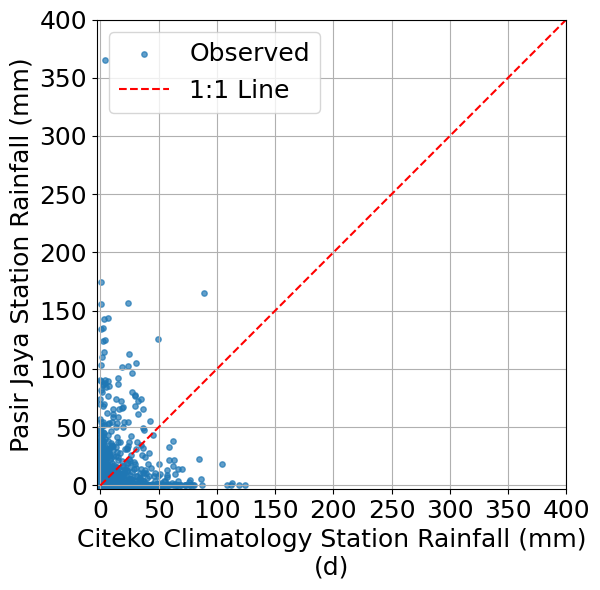

In [24]:
plot([pasirjaya_citeko], 'Citeko Climatology', ['Pasir Jaya'])